In [77]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

In [78]:
def generate_trajectory():
    a_obs = []
    d_obs = []
    e_obs = []
    n_obs = []
    hist = []

    e = np.random.randint(low=0, high=2)

    for d in range(1,7):
        amount = None

        if d == 2:
            if np.random.rand() < 0.75:
                amount = -1
            else:
                amount = -2
            category = 'DO'
        
        if d != 2:
            if d not in (4,5) or 'SAL' in hist:
                amount = 0
                category = 'NONE'
            else:
                if d == 4:
                    if np.random.rand() < 0.5:
                        amount = 1 if e == 0 else 2
                        category = 'SAL'
                    else:
                        amount = 0
                        category = 'NONE' 
                else:
                    amount = 1 if e == 0 else 2
                    category = 'SAL' 

        if d > 1 and hist[-1] == 'SAL':
            amount = -1 * a_obs[-1]
            category = 'EFT' 

        n_obs.append(sum(a_obs[-3:]))
        a_obs.append(amount)
        d_obs.append(d)
        e_obs.append(e)
        hist.append(category)

    return pd.DataFrame({
        'D': d_obs,
        'N': n_obs,
        'E': e_obs,
        'A': a_obs
    })

def create_dataset(n=10):
    all_trajectories = []

    for i in range(n):
        all_trajectories.append(generate_trajectory())
    return pd.concat(all_trajectories)

In [79]:
df = generate_trajectory()

In [80]:
df

,D,N,E,A
0,1,0,1,0
1,2,0,1,-1
2,3,-1,1,0
3,4,-1,1,2
4,5,1,1,-2
5,6,0,1,0


In [81]:
amounts == [0, -2, 0, 2, -2, 1]

False

In [82]:
unique_trajectories = []
unique_dfs = []

for i in range(100000):
    df = generate_trajectory()
    amounts = list(df.A.values)
    
    if amounts not in unique_trajectories:
        unique_trajectories.append(amounts)
        unique_dfs.append(df)

In [83]:
len(unique_trajectories)

8

In [84]:
model = BayesianNetwork([ 
    ('D', 'A'),
    ('N', 'A'),
    ('E', 'A')
])

In [85]:
data = create_dataset(n=1000000)

In [86]:
cpd_D = MaximumLikelihoodEstimator(model, data).estimate_cpd('D')
cpd_N = MaximumLikelihoodEstimator(model, data).estimate_cpd('N')
cpd_E = MaximumLikelihoodEstimator(model, data).estimate_cpd('E')
cpd_A = MaximumLikelihoodEstimator(model, data).estimate_cpd('A')
model.add_cpds(cpd_D, cpd_N, cpd_E, cpd_A)

In [87]:
infer = VariableElimination(model)

In [88]:
print(infer.query(['A'], evidence={'D': 6, 'N': 1, 'E': 0}))

+-------+----------+
| A     |   phi(A) |
+=======+==========+
| A(-2) |   0.0000 |
+-------+----------+
| A(-1) |   1.0000 |
+-------+----------+
| A(0)  |   0.0000 |
+-------+----------+
| A(1)  |   0.0000 |
+-------+----------+
| A(2)  |   0.0000 |
+-------+----------+


In [89]:
height_maps = []
es = []

for i in range(len(unique_dfs)):
    d_obs = unique_dfs[i].D.values
    a_obs = unique_dfs[i].A.values
    n_obs = unique_dfs[i].N.values
    e_obs = unique_dfs[i].E.values
        
    heights = []
    for d, n, e in zip(d_obs, n_obs, e_obs):
        heights.append(np.flip(infer.query(['A'], evidence={'D': d, 'N': n, 'E': e}).values))

    heights = np.array(heights)
    height_maps.append(heights)
    es.append(e_obs[0])

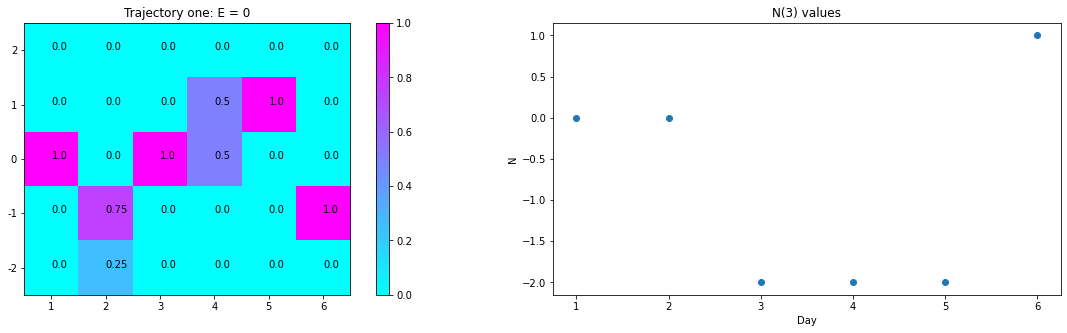

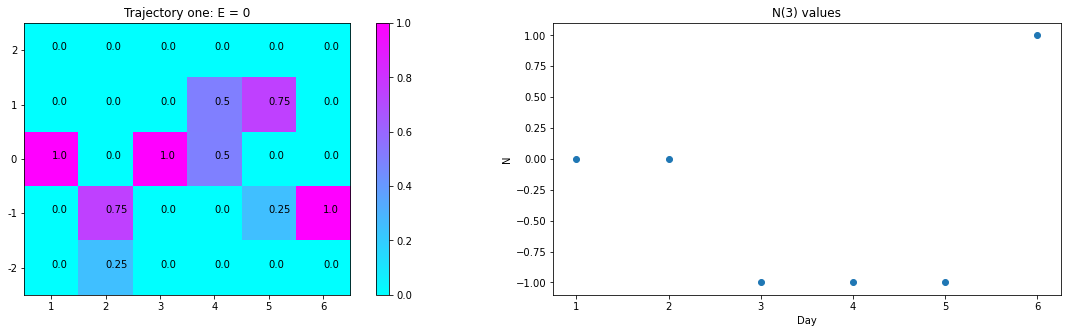

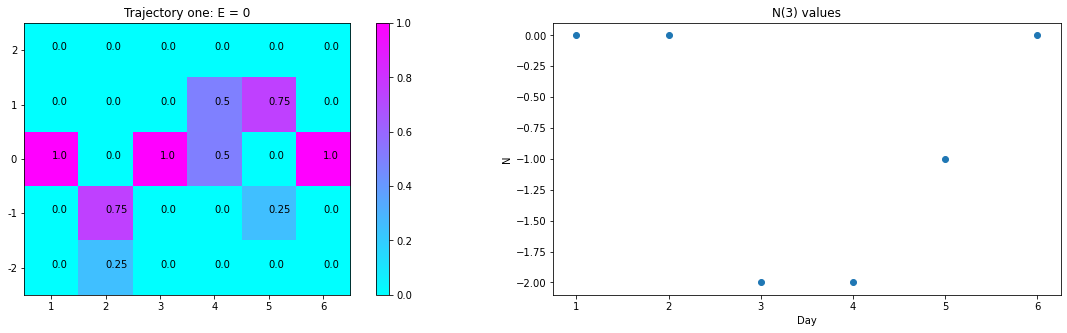

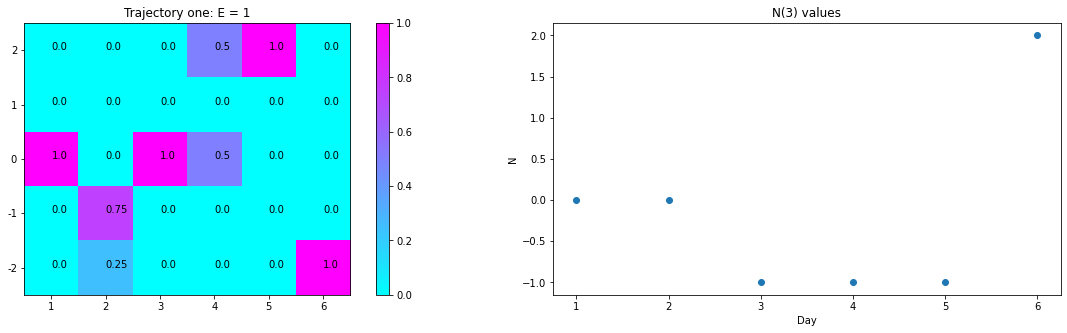

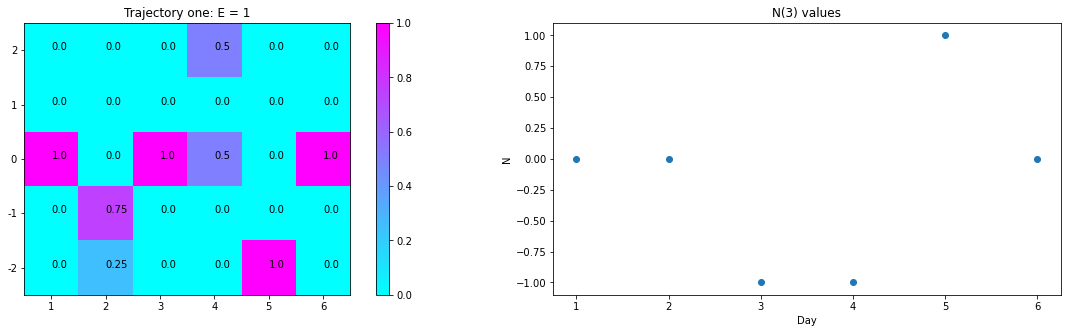

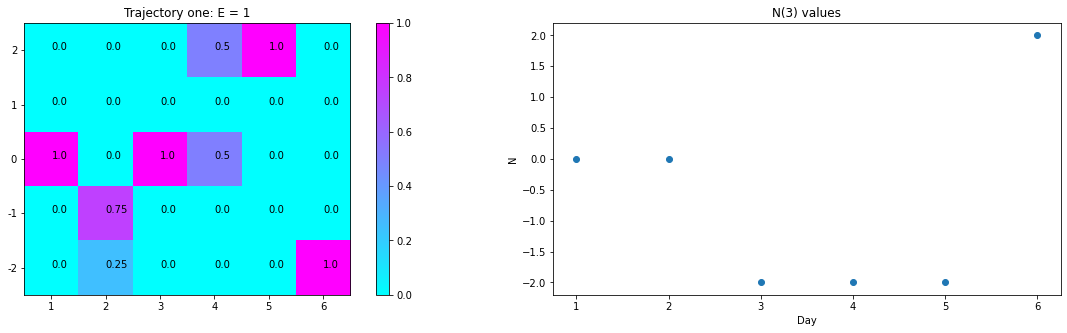

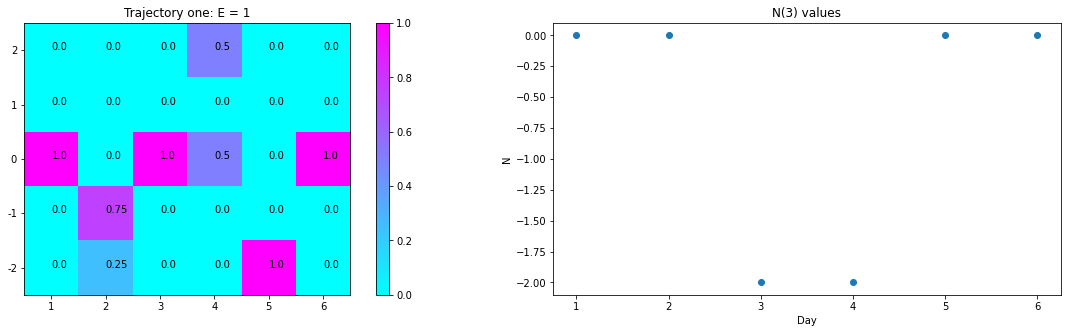

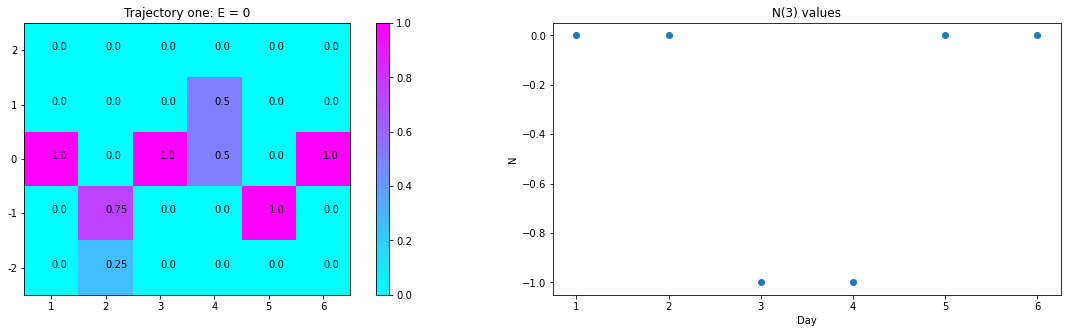

In [90]:
for i in range(len(height_maps)):
    fig, ax = plt.subplots(1, 2)
    
    im = ax[0].imshow(height_maps[i].T, cmap='cool')

    for row in range(height_maps[i].T.shape[0]):
        for col in range(height_maps[i].T.shape[1]):
            ax[0].text(col, row, round(height_maps[i].T[row, col], 2), color='black')

    ax[0].set_yticks(range(0, 5), labels=np.flip(range(-2, 3)))
    ax[0].set_xticks(range(0, 6), labels=range(1, 7))
    ax[0].set_title(f'Trajectory one: E = {unique_dfs[i].E.values[0]}')

    ax[1].scatter(unique_dfs[i].D.values, unique_dfs[i].N.values)
    ax[1].set_xlabel('Day')
    ax[1].set_ylabel('N')
    ax[1].set_title('N(3) values')

    fig.colorbar(im , ax=ax[0])
    fig.set_size_inches(20, 5)
    plt.show()

In [91]:
height_maps = np.array(height_maps)

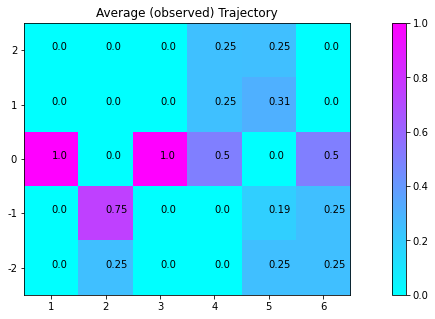

In [92]:
ave_h = height_maps.mean(axis=0)

plt.imshow(ave_h.T, cmap='cool')

for row in range(ave_h.T.shape[0]):
    for col in range(ave_h.T.shape[1]):
        plt.text(col, row, round(ave_h.T[row, col], 2), color='black')

plt.yticks(range(0, 5), labels=np.flip(range(-2, 3)))
plt.xticks(range(0, 6), labels=range(1, 7))

plt.colorbar()
plt.title('Average (observed) Trajectory')
plt.gcf().set_size_inches(15, 5)
plt.show()

In [93]:
heights_E_0 = []
heights_E_1 = []

for i in range(len(unique_dfs)):
    if (unique_dfs[i].A.values == 2).any():
        heights_E_1.append(height_maps[i])
    else:
        heights_E_0.append(height_maps[i])

heights_E_0 = np.array(heights_E_0)
heights_E_1 = np.array(heights_E_1)

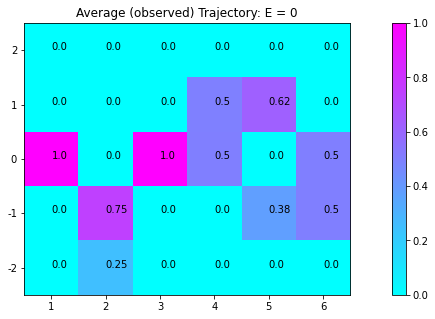

In [94]:
ave_h = heights_E_0.mean(axis=0)

plt.imshow(ave_h.T, cmap='cool')

for row in range(ave_h.T.shape[0]):
    for col in range(ave_h.T.shape[1]):
        plt.text(col, row, round(ave_h.T[row, col], 2), color='black')

plt.yticks(range(0, 5), labels=np.flip(range(-2, 3)))
plt.xticks(range(0, 6), labels=range(1, 7))

plt.colorbar()
plt.title('Average (observed) Trajectory: E = 0')
plt.gcf().set_size_inches(15, 5)
plt.show()

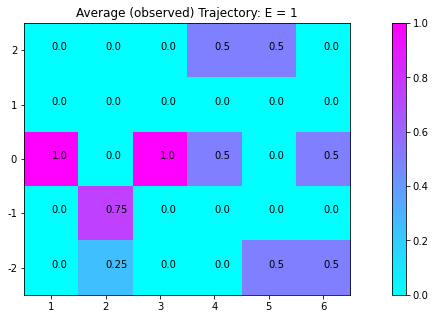

In [95]:
ave_h = heights_E_1.mean(axis=0)

plt.imshow(ave_h.T, cmap='cool')

for row in range(ave_h.T.shape[0]):
    for col in range(ave_h.T.shape[1]):
        plt.text(col, row, round(ave_h.T[row, col], 2), color='black')

plt.yticks(range(0, 5), labels=np.flip(range(-2, 3)))
plt.xticks(range(0, 6), labels=range(1, 7))

plt.colorbar()
plt.title('Average (observed) Trajectory: E = 1')
plt.gcf().set_size_inches(15, 5)
plt.show()